<a href="https://colab.research.google.com/github/golfwhiper28/nida_is/blob/main/code/Investment_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Improt Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys,os,time,datetime
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import Sequential
from sklearn import preprocessing
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix,classification_report
from google.colab import drive
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding

/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding


#Import Data

In [ ]:
df_lstm_btc = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/LSTM_BTC_result.xlsx")
df_lstm_btc["coins"] = "BTC"
df_lstm_btc=df_lstm_btc.reset_index()
df_lstm_sol = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/LSTM_SOL_result.xlsx")
df_lstm_sol["coins"] = "SOL"
df_lstm_sol=df_lstm_sol.reset_index()
df_lstm = df_lstm_btc.append(df_lstm_sol)

df_gru_btc = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/GRU_BTC_result.xlsx")
df_gru_btc["coins"] = "BTC"
df_gru_btc=df_gru_btc.reset_index()
df_gru_sol = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/GRU_SOL_result.xlsx")
df_gru_sol["coins"] = "SOL"
df_gru_sol=df_gru_sol.reset_index()
df_gru = df_gru_btc.append(df_gru_sol)

df_rnn_btc = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/SimpleRNN_BTC_result.xlsx")
df_rnn_btc["coins"] = "BTC"
df_rnn_btc=df_rnn_btc.reset_index()
df_rnn_sol = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/SimpleRNN_SOL_result.xlsx")
df_rnn_sol["coins"] = "SOL"
df_rnn_sol=df_rnn_sol.reset_index()
df_rnn = df_rnn_btc.append(df_rnn_sol)

df_lgbm_ma_btc = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/lgbm_ma_BTC_result.xlsx")
df_lgbm_ma_btc["coins"] = "BTC"
df_lgbm_ma_btc=df_lgbm_ma_btc.reset_index()
df_lgbm_ma_sol = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/IS_NIDA/Coding/lgbm_ma_SOL_result.xlsx")
df_lgbm_ma_sol["coins"] = "SOL"
df_lgbm_ma_sol=df_lgbm_ma_sol.reset_index()
df_lgbm_ma = df_lgbm_ma_btc.append(df_lgbm_ma_sol)

#LSTM

In [ ]:
df_lstm_btc.tail()

,index,price_t4,true_price_t5,LSTM,coins
1229,1229,38543.11,38331.54,39007.886982,BTC
1230,1230,38331.54,38564.44,38525.673136,BTC
1231,1231,38564.44,38560.15,38645.441527,BTC
1232,1232,38560.15,38608.63,38546.303314,BTC
1233,1233,38608.63,38596.11,38334.971676,BTC


In [ ]:
budget=1000
sol=0
budget_hist_btc=[budget]
budget_hist=[budget]
budget_hist_sol=[budget]
btcs_hist_btc=[sol]
btcs_hist_sol=[sol]
stopper=0.15
fee = 0.001
temp_buy_price=0
cost=0
n = len(df_lstm_btc)
print("total hours: ",n)
for i in range(n):
  if(i<=(n/2)):
    print("-------------------------------------")
    if (df_lstm_sol["price_t4"][i]<df_lstm_sol["LSTM"][i]) and (sol<=0):
      print("BUY: ", i)
      sol = budget/((1+fee)*df_lstm_sol["price_t4"][i])
      budget = budget - (sol*((1+fee)*df_lstm_sol["price_t4"][i]))
      budget=0
      temp_buy_price=df_lstm_sol["price_t4"][i]
      cost=(sol*((1+fee)*df_lstm_sol["price_t4"][i]))
      print("SOL buy price: ", df_lstm_sol["price_t4"][i])
      print("SOL: ", sol)
      print("budget: ", budget)
      print("cost: ", (sol*((1+fee)*df_lstm_sol["price_t4"][i])))
    elif (df_lstm_sol["price_t4"][i]>df_lstm_sol["LSTM"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
      if (df_lstm_sol["price_t4"][i]>(temp_buy_price)):
        print("SELL (Case 1): ", i)
        budget = budget + (sol*((1-fee)*df_lstm_sol["price_t4"][i]))
        print("SOL sell price: ", df_lstm_sol["price_t4"][i])
        print("SOL: ", sol)
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_lstm_sol["price_t4"][i])))
        sol = 0
      elif (((sol*((1-fee)*df_lstm_sol["price_t4"][i]))<(cost*(1-stopper)))):
        print("SELL (Case 2): ", i)
        print("SOL buy price: ", temp_buy_price)
        print("SOL sell price: ", df_lstm_sol["price_t4"][i])
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_lstm_sol["price_t4"][i])))
        budget = budget + (sol*((1-fee)*df_lstm_sol["price_t4"][i]))
        sol = 0
    # else:
    #   print("SELL: ", i)
    #   budget = budget + (sol*((1-fee)*result["price_t4"][i]))
    #   print("SOL sell price: ", result["price_t4"][i])
    #   print("SOL: ", sol)
    #   print("Stopper value: ", (cost*(1-stopper)))
    #   print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
    #   sol = 0
    budget_hist_sol=budget_hist_sol+[budget]        
    btcs_hist_sol=btcs_hist_sol+[sol]
  else:
    if(i==618):
      print("SOL Sell: ", i)
      print("SELL (Case 1): ", i)
      budget = budget + (sol*((1-fee)*df_lstm_sol["price_t4"][i]))
      print("SOL sell price: ", df_lstm_sol["price_t4"][i])
      print("SOL: ", sol)
      print("revenue: ", (sol*((1-fee)*df_lstm_sol["price_t4"][i])))
      sol = 0
      budget_hist_sol=budget_hist_sol+[budget]        
      btcs_hist_sol=btcs_hist_sol+[sol]
    print("-------------------------------------")
    if (df_lstm_btc["price_t4"][i]<df_lstm_btc["LSTM"][i]) and (sol<=0):
      print("BUY: ", i)
      sol = budget/((1+fee)*df_lstm_btc["price_t4"][i])
      budget = budget - (sol*((1+fee)*df_lstm_btc["price_t4"][i]))
      budget=0
      temp_buy_price=df_lstm_btc["price_t4"][i]
      cost=(sol*((1+fee)*df_lstm_btc["price_t4"][i]))
      print("BTC buy price: ", df_lstm_btc["price_t4"][i])
      print("BTC: ", sol)
      print("budget: ", budget)
      print("cost: ", (sol*((1+fee)*df_lstm_btc["price_t4"][i])))
    elif (df_lstm_btc["price_t4"][i]>df_lstm_btc["LSTM"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
      if (df_lstm_btc["price_t4"][i]>(temp_buy_price)):
        print("SELL (Case 1): ", i)
        budget = budget + (sol*((1-fee)*df_lstm_btc["price_t4"][i]))
        print("BTC sell price: ", df_lstm_btc["price_t4"][i])
        print("BTC: ", sol)
        print("revenue: ", (sol*((1-fee)*df_lstm_btc["price_t4"][i])))
        sol = 0
      elif (((sol*((1-fee)*df_lstm_btc["price_t4"][i]))<(cost*(1-stopper)))):
        print("SELL (Case 2): ", i)
        print("BTC buy price: ", temp_buy_price)
        print("BTC sell price: ", df_lstm_btc["price_t4"][i])
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_lstm_btc["price_t4"][i])))
        budget = budget + (sol*((1-fee)*df_lstm_btc["price_t4"][i]))
        sol = 0
    if(i>618):
      budget_hist_btc=budget_hist_btc+[budget]        
      btcs_hist_btc=btcs_hist_btc+[sol]


  budget_hist=budget_hist+[budget]
  # btcs_hist=btcs_hist+[sol]

total hours:  1234
-------------------------------------
BUY:  0
SOL buy price:  86.86
SOL:  11.501277906988248
budget:  0
cost:  1000.0000000000001
-------------------------------------
-------------------------------------
SELL (Case 1):  2
SOL sell price:  88.91
SOL:  11.501277906988248
Stopper value:  850.0000000000001
revenue:  1021.5560400916148
-------------------------------------
-------------------------------------
-------------------------------------
BUY:  5
SOL buy price:  87.03
SOL:  11.726249621820383
budget:  0
cost:  1021.5560400916148
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
SELL (Case 1):  9
SOL sell price:  87.87
SOL:  11.726249621820383
Stopper value:  868.3226340778725
revenue:  1029.3551687150878
-------------------------------------
-------------------------------------
-------------------------------------
BUY:  12
SOL buy price:  86.2
SOL:  11.929545

Text(0.5, 0, 'Hour')

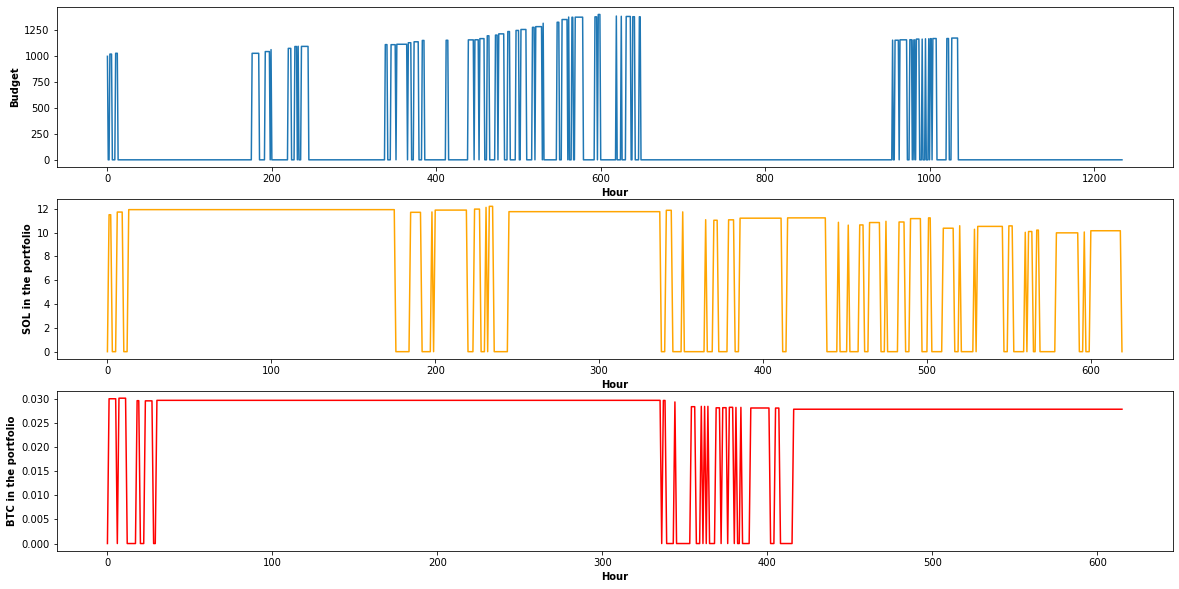

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget", fontweight="bold")
ax1.set_xlabel("Hour", fontweight="bold")

ax2.plot(btcs_hist_sol,color="orange")
ax2.set_ylabel("SOL in the portfolio", fontweight="bold")
ax2.set_xlabel("Hour", fontweight="bold")

ax3.plot(btcs_hist_btc,color="red")
ax3.set_ylabel("BTC in the portfolio", fontweight="bold")
ax3.set_xlabel("Hour", fontweight="bold")

In [ ]:
# fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20,10))
# ax1.plot(budget_hist)
# ax1.set_ylabel("Budget", fontweight="bold")
# ax1.set_xlabel("Hour", fontweight="bold")

# ax2.plot(btcs_hist_sol,color="orange")
# ax2.set_ylabel("SOL in the portfolio", fontweight="bold")
# ax2.set_xlabel("Hour", fontweight="bold")

# ax3.plot(btcs_hist_btc,color="red")
# ax3.set_ylabel("BTC in the portfolio", fontweight="bold")
# ax3.set_xlabel("Hour", fontweight="bold")

Text(0.5, 0, 'Hour')

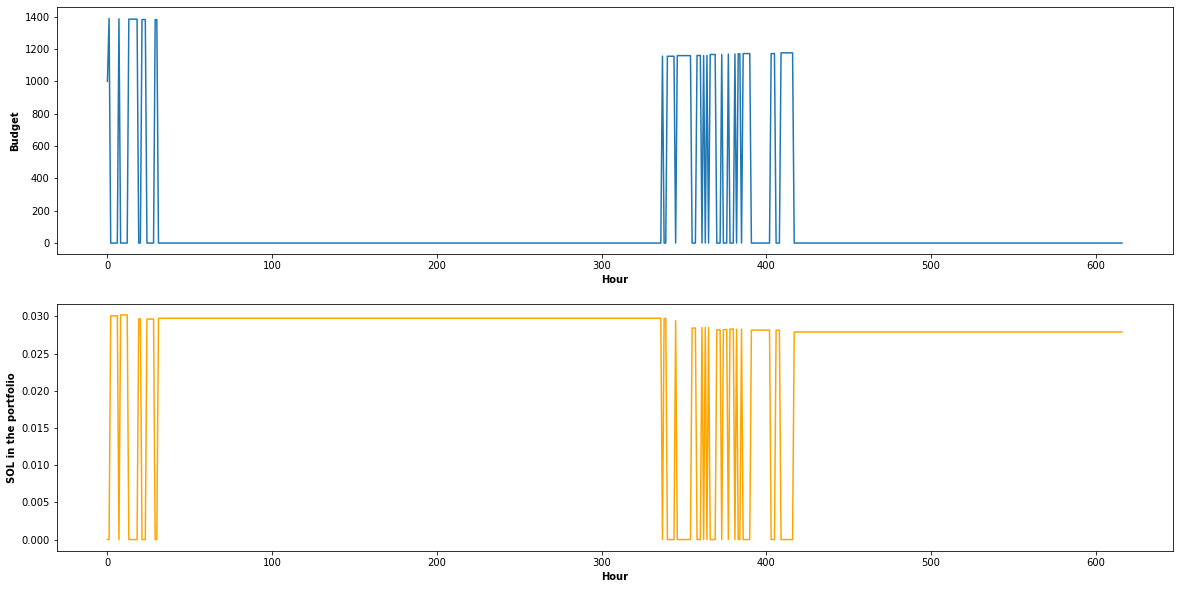

In [ ]:
# fig, (ax1,ax2) = plt.subplots(2,figsize=(20,10))
# ax1.plot(budget_hist_btc)
# ax1.set_ylabel("Budget", fontweight="bold")
# ax1.set_xlabel("Hour", fontweight="bold")

# ax2.plot(btcs_hist_btc,color="orange")
# ax2.set_ylabel("SOL in the portfolio", fontweight="bold")
# ax2.set_xlabel("Hour", fontweight="bold")

#GRU

In [ ]:
df_gru_btc.head(1)

,index,price_t4,true_price_t5,GRU,coins
0,0,41869.16,42208.71,42234.637493,BTC


In [ ]:
budget=1000
sol=0

budget_hist_btc=[budget]
budget_hist=[budget]
budget_hist_sol=[budget]
btcs_hist_btc=[sol]
btcs_hist_sol=[sol]
stopper=0.15
fee = 0.001
temp_buy_price=0
cost=0
n = len(df_gru_btc)
print("total hours: ",n)
for i in range(n):
  if(i<=(n/2)):
    print("-------------------------------------")
    if (df_gru_sol["price_t4"][i]<df_gru_sol["GRU"][i]) and (sol<=0):
      print("BUY: ", i)
      sol = budget/((1+fee)*df_gru_sol["price_t4"][i])
      budget = budget - (sol*((1+fee)*df_gru_sol["price_t4"][i]))
      budget=0
      temp_buy_price=df_gru_sol["price_t4"][i]
      cost=(sol*((1+fee)*df_gru_sol["price_t4"][i]))
      print("SOL buy price: ", df_gru_sol["price_t4"][i])
      print("SOL: ", sol)
      print("budget: ", budget)
      print("cost: ", (sol*((1+fee)*df_gru_sol["price_t4"][i])))
    elif (df_gru_sol["price_t4"][i]>df_gru_sol["GRU"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
      if (df_gru_sol["price_t4"][i]>(temp_buy_price)):
        print("SELL (Case 1): ", i)
        budget = budget + (sol*((1-fee)*df_gru_sol["price_t4"][i]))
        print("SOL sell price: ", df_gru_sol["price_t4"][i])
        print("SOL: ", sol)
        print("revenue: ", (sol*((1-fee)*df_gru_sol["price_t4"][i])))
        sol = 0
      elif (((sol*((1-fee)*df_gru_sol["price_t4"][i]))<(cost*(1-stopper)))):
        print("SELL (Case 2): ", i)
        print("SOL buy price: ", temp_buy_price)
        print("SOL sell price: ", df_gru_sol["price_t4"][i])
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_gru_sol["price_t4"][i])))
        budget = budget + (sol*((1-fee)*df_gru_sol["price_t4"][i]))
        sol = 0
    # else:
    #   print("SELL: ", i)
    #   budget = budget + (sol*((1-fee)*result["price_t4"][i]))
    #   print("SOL sell price: ", result["price_t4"][i])
    #   print("SOL: ", sol)
    #   print("Stopper value: ", (cost*(1-stopper)))
    #   print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
    #   sol = 0
    budget_hist_sol=budget_hist_sol+[budget]        
    btcs_hist_sol=btcs_hist_sol+[sol]
  else:
    if(i==618):
      print("SOL Sell: ", i)
      print("SELL (Case 1): ", i)
      budget = budget + (sol*((1-fee)*df_gru_sol["price_t4"][i]))
      print("SOL sell price: ", df_gru_sol["price_t4"][i])
      print("SOL: ", sol)
      print("Stopper value: ", (cost*(1-stopper)))
      print("revenue: ", (sol*((1-fee)*df_gru_sol["price_t4"][i])))
      sol = 0
      budget_hist_sol=budget_hist_sol+[budget]        
      btcs_hist_sol=btcs_hist_sol+[sol]
    print("-------------------------------------")
    if (df_gru_btc["price_t4"][i]<df_gru_btc["GRU"][i]) and (sol<=0):
      print("BUY: ", i)
      sol = budget/((1+fee)*df_gru_btc["price_t4"][i])
      budget = budget - (sol*((1+fee)*df_gru_btc["price_t4"][i]))
      budget=0
      temp_buy_price=df_gru_btc["price_t4"][i]
      cost=(sol*((1+fee)*df_gru_btc["price_t4"][i]))
      print("BTC buy price: ", df_gru_btc["price_t4"][i])
      print("BTC: ", sol)
      print("budget: ", budget)
      print("cost: ", (sol*((1+fee)*df_gru_btc["price_t4"][i])))
    elif (df_gru_btc["price_t4"][i]>df_gru_btc["GRU"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
      if (df_gru_btc["price_t4"][i]>(temp_buy_price)):
        print("SELL (Case 1): ", i)
        budget = budget + (sol*((1-fee)*df_gru_btc["price_t4"][i]))
        print("BTC sell price: ", df_gru_btc["price_t4"][i])
        print("BTC: ", sol)
        print("revenue: ", (sol*((1-fee)*df_gru_btc["price_t4"][i])))
        sol = 0
      elif (((sol*((1-fee)*df_gru_btc["price_t4"][i]))<(cost*(1-stopper)))):
        print("SELL (Case 2): ", i)
        print("BTC buy price: ", temp_buy_price)
        print("BTC sell price: ", df_gru_btc["price_t4"][i])
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_gru_btc["price_t4"][i])))
        budget = budget + (sol*((1-fee)*df_gru_btc["price_t4"][i]))
        sol = 0
    if(i>618):
      budget_hist_btc=budget_hist_btc+[budget]        
      btcs_hist_btc=btcs_hist_btc+[sol]

  budget_hist=budget_hist+[budget]
  # btcs_hist=btcs_hist+[sol]

total hours:  1234
-------------------------------------
BUY:  0
SOL buy price:  86.86
SOL:  11.501277906988248
budget:  0
cost:  1000.0000000000001
-------------------------------------
-------------------------------------
SELL (Case 1):  2
SOL sell price:  88.91
SOL:  11.501277906988248
revenue:  1021.5560400916148
-------------------------------------
-------------------------------------
-------------------------------------
BUY:  5
SOL buy price:  87.03
SOL:  11.726249621820383
budget:  0
cost:  1021.5560400916148
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
SELL (Case 1):  9
SOL sell price:  87.87
SOL:  11.726249621820383
revenue:  1029.3551687150878
-------------------------------------
-------------------------------------
-------------------------------------
BUY:  12
SOL buy price:  86.2
SOL:  11.929545729387641
budget:  0
cost:  1029.3551687150878
---------------------

Text(0.5, 0, 'Hour')

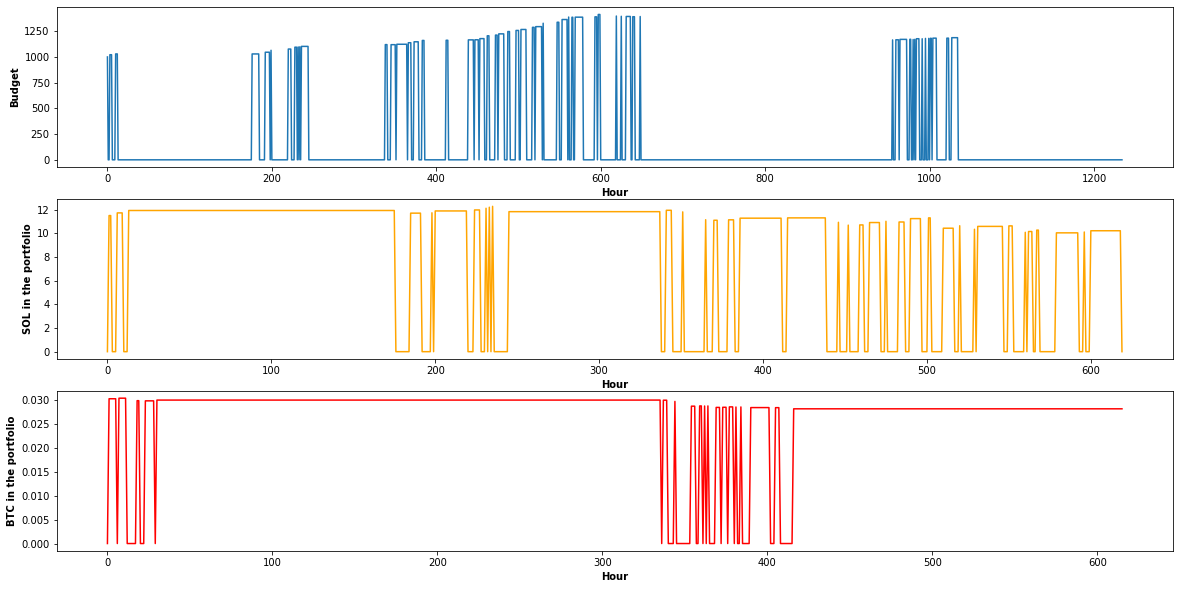

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget", fontweight="bold")
ax1.set_xlabel("Hour", fontweight="bold")

ax2.plot(btcs_hist_sol,color="orange")
ax2.set_ylabel("SOL in the portfolio", fontweight="bold")
ax2.set_xlabel("Hour", fontweight="bold")

ax3.plot(btcs_hist_btc,color="red")
ax3.set_ylabel("BTC in the portfolio", fontweight="bold")
ax3.set_xlabel("Hour", fontweight="bold")

#SimpleRNN

In [ ]:
df_rnn_btc.head(1)

,index,price_t4,true_price_t5,SimpleRNN,coins
0,0,41869.16,42208.71,42064.88875,BTC


In [ ]:
budget=1000
sol=0
budget_hist_btc=[budget]
budget_hist=[budget]
budget_hist_sol=[budget]
btcs_hist_btc=[sol]
btcs_hist_sol=[sol]
stopper=0.15
fee = 0.001
temp_buy_price=0
cost=0
n = len(df_rnn_sol)
print("total hours: ",n)
for i in range(n):
  if(i<=(n/2)):
    print("-------------------------------------")
    if (df_rnn_sol["price_t4"][i]<df_rnn_sol["SimpleRNN"][i]) and (sol<=0):
      print("BUY: ", i)
      sol = budget/((1+fee)*df_rnn_sol["price_t4"][i])
      budget = budget - (sol*((1+fee)*df_rnn_sol["price_t4"][i]))
      budget=0
      temp_buy_price=df_rnn_sol["price_t4"][i]
      cost=(sol*((1+fee)*df_rnn_sol["price_t4"][i]))
      print("SOL buy price: ", df_rnn_sol["price_t4"][i])
      print("SOL: ", sol)
      print("budget: ", budget)
      print("cost: ", (sol*((1+fee)*df_rnn_sol["price_t4"][i])))
    elif (df_rnn_sol["price_t4"][i]>df_rnn_sol["SimpleRNN"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
      if (df_rnn_sol["price_t4"][i]>(temp_buy_price)):
        print("SELL (Case 1): ", i)
        budget = budget + (sol*((1-fee)*df_rnn_sol["price_t4"][i]))
        print("SOL sell price: ", df_rnn_sol["price_t4"][i])
        print("SOL: ", sol)
        print("revenue: ", (sol*((1-fee)*df_rnn_sol["price_t4"][i])))
        sol = 0
      elif (((sol*((1-fee)*df_rnn_sol["price_t4"][i]))<(cost*(1-stopper)))):
        print("SELL (Case 2): ", i)
        print("SOL buy price: ", temp_buy_price)
        print("SOL sell price: ", df_SimpleRNN_sol["price_t4"][i])
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_rnn_sol["price_t4"][i])))
        budget = budget + (sol*((1-fee)*df_rnn_sol["price_t4"][i]))
        sol = 0
    # else:
    #   print("SELL: ", i)
    #   budget = budget + (sol*((1-fee)*result["price_t4"][i]))
    #   print("SOL sell price: ", result["price_t4"][i])
    #   print("SOL: ", sol)
    #   print("Stopper value: ", (cost*(1-stopper)))
    #   print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
    #   sol = 0
    budget_hist_sol=budget_hist_sol+[budget]        
    btcs_hist_sol=btcs_hist_sol+[sol]
  else:
    if(i==618):
      print("SOL Sell: ", i)
      print("SELL (Case 1): ", i)
      budget = budget + (sol*((1-fee)*df_rnn_sol["price_t4"][i]))
      print("SOL sell price: ", df_rnn_sol["price_t4"][i])
      print("SOL: ", sol)
      print("Stopper value: ", (cost*(1-stopper)))
      print("revenue: ", (sol*((1-fee)*df_rnn_sol["price_t4"][i])))
      sol = 0
      budget_hist_sol=budget_hist_sol+[budget]        
      btcs_hist_sol=btcs_hist_sol+[sol]
    print("-------------------------------------")
    if (df_rnn_btc["price_t4"][i]<df_rnn_btc["SimpleRNN"][i]) and (sol<=0):
      print("BUY: ", i)
      sol = budget/((1+fee)*df_rnn_btc["price_t4"][i])
      budget = budget - (sol*((1+fee)*df_rnn_btc["price_t4"][i]))
      budget=0
      temp_buy_price=df_rnn_btc["price_t4"][i]
      cost=(sol*((1+fee)*df_rnn_btc["price_t4"][i]))
      print("BTC buy price: ", df_rnn_btc["price_t4"][i])
      print("BTC: ", sol)
      print("budget: ", budget)
      print("cost: ", (sol*((1+fee)*df_rnn_btc["price_t4"][i])))
    elif (df_rnn_btc["price_t4"][i]>df_rnn_btc["SimpleRNN"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
      if (df_rnn_btc["price_t4"][i]>(temp_buy_price)):
        print("SELL (Case 1): ", i)
        budget = budget + (sol*((1-fee)*df_rnn_btc["price_t4"][i]))
        print("BTC sell price: ", df_rnn_btc["price_t4"][i])
        print("BTC: ", sol)
        print("revenue: ", (sol*((1-fee)*df_rnn_btc["price_t4"][i])))
        sol = 0
      elif (((sol*((1-fee)*df_rnn_btc["price_t4"][i]))<(cost*(1-stopper)))):
        print("SELL (Case 2): ", i)
        print("BTC buy price: ", temp_buy_price)
        print("BTC sell price: ", df_rnn_btc["price_t4"][i])
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_rnn_btc["price_t4"][i])))
        budget = budget + (sol*((1-fee)*df_rnn_btc["price_t4"][i]))
        sol = 0
    if(i>618):
      budget_hist_btc=budget_hist_btc+[budget]        
      btcs_hist_btc=btcs_hist_btc+[sol]


  budget_hist=budget_hist+[budget]
  # btcs_hist=btcs_hist+[sol]

total hours:  1234
-------------------------------------
BUY:  0
SOL buy price:  86.86
SOL:  11.501277906988248
budget:  0
cost:  1000.0000000000001
-------------------------------------
-------------------------------------
SELL (Case 1):  2
SOL sell price:  88.91
SOL:  11.501277906988248
revenue:  1021.5560400916148
-------------------------------------
-------------------------------------
-------------------------------------
BUY:  5
SOL buy price:  87.03
SOL:  11.726249621820383
budget:  0
cost:  1021.5560400916148
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
SELL (Case 1):  9
SOL sell price:  87.87
SOL:  11.726249621820383
revenue:  1029.3551687150878
-------------------------------------
-------------------------------------
-------------------------------------
BUY:  12
SOL buy price:  86.2
SOL:  11.929545729387641
budget:  0
cost:  1029.3551687150878
---------------------

Text(0.5, 0, 'Hour')

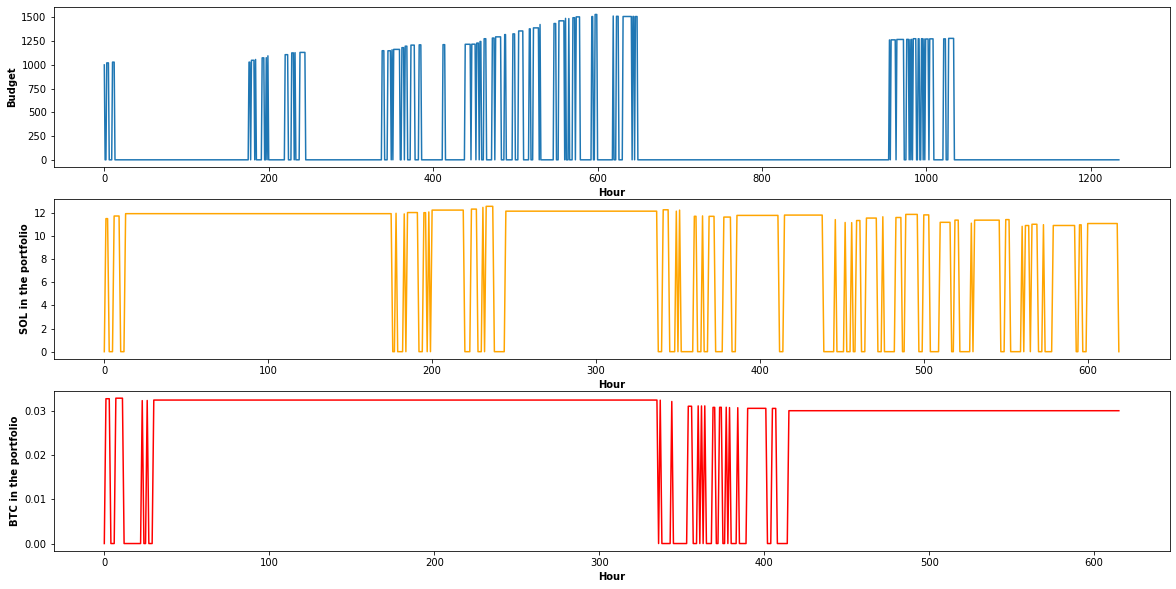

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget", fontweight="bold")
ax1.set_xlabel("Hour", fontweight="bold")

ax2.plot(btcs_hist_sol,color="orange")
ax2.set_ylabel("SOL in the portfolio", fontweight="bold")
ax2.set_xlabel("Hour", fontweight="bold")

ax3.plot(btcs_hist_btc,color="red")
ax3.set_ylabel("BTC in the portfolio", fontweight="bold")
ax3.set_xlabel("Hour", fontweight="bold")

#LGBM

In [ ]:
df_lgbm_ma_btc.head(1)

,index,price_t4,true_price_t5,lgbm_price,move_avg,coins
0,0,41869.16,42208.71,42184.781704,42037.705,BTC


In [ ]:
budget=1000
sol=0
budget_hist_btc=[budget]
budget_hist=[budget]
budget_hist_sol=[budget]
btcs_hist_btc=[sol]
btcs_hist_sol=[sol]
stopper=0.15
fee = 0.001
temp_buy_price=0
cost=0
n = len(df_lgbm_ma_sol)
print("total hours: ",n)
for i in range(n):
  if(i<=(n/2)):
    print("-------------------------------------")
    if (df_lgbm_ma_sol["price_t4"][i]<df_lgbm_ma_sol["lgbm_price"][i]) and (sol<=0):
      print("BUY: ", i)
      sol = budget/((1+fee)*df_lgbm_ma_sol["price_t4"][i])
      budget = budget - (sol*((1+fee)*df_lgbm_ma_sol["price_t4"][i]))
      budget=0
      temp_buy_price=df_lgbm_ma_sol["price_t4"][i]
      cost=(sol*((1+fee)*df_lgbm_ma_sol["price_t4"][i]))
      print("SOL buy price: ", df_lgbm_ma_sol["price_t4"][i])
      print("SOL: ", sol)
      print("budget: ", budget)
      print("cost: ", (sol*((1+fee)*df_lgbm_ma_sol["price_t4"][i])))
    elif (df_lgbm_ma_sol["price_t4"][i]>df_lgbm_ma_sol["lgbm_price"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
      if (df_lgbm_ma_sol["price_t4"][i]>(temp_buy_price)):
        print("SELL (Case 1): ", i)
        budget = budget + (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i]))
        print("SOL sell price: ", df_lgbm_ma_sol["price_t4"][i])
        print("SOL: ", sol)
        print("revenue: ", (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i])))
        sol = 0
      elif (((sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i]))<(cost*(1-stopper)))):
        print("SELL (Case 2): ", i)
        print("SOL buy price: ", temp_buy_price)
        print("SOL sell price: ", df_lgbm_price_sol["price_t4"][i])
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i])))
        budget = budget + (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i]))
        sol = 0
    # else:
    #   print("SELL: ", i)
    #   budget = budget + (sol*((1-fee)*result["price_t4"][i]))
    #   print("SOL sell price: ", result["price_t4"][i])
    #   print("SOL: ", sol)
    #   print("Stopper value: ", (cost*(1-stopper)))
    #   print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
    #   sol = 0
    budget_hist_sol=budget_hist_sol+[budget]        
    btcs_hist_sol=btcs_hist_sol+[sol]
  else:
    if(i==618):
      print("SOL Sell: ", i)
      print("SELL (Case 1): ", i)
      budget = budget + (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i]))
      print("SOL sell price: ", df_lgbm_ma_sol["price_t4"][i])
      print("SOL: ", sol)
      print("Stopper value: ", (cost*(1-stopper)))
      print("revenue: ", (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i])))
      sol = 0
      budget_hist_sol=budget_hist_sol+[budget]        
      btcs_hist_sol=btcs_hist_sol+[sol]
    print("-------------------------------------")
    if (df_lgbm_ma_btc["price_t4"][i]<df_lgbm_ma_btc["lgbm_price"][i]) and (sol<=0):
      print("BUY: ", i)
      sol = budget/((1+fee)*df_lgbm_ma_btc["price_t4"][i])
      budget = budget - (sol*((1+fee)*df_lgbm_ma_btc["price_t4"][i]))
      budget=0
      temp_buy_price=df_lgbm_ma_btc["price_t4"][i]
      cost=(sol*((1+fee)*df_lgbm_ma_btc["price_t4"][i]))
      print("BTC buy price: ", df_lgbm_ma_btc["price_t4"][i])
      print("BTC: ", sol)
      print("budget: ", budget)
      print("cost: ", (sol*((1+fee)*df_lgbm_ma_btc["price_t4"][i])))
    elif (df_lgbm_ma_btc["price_t4"][i]>df_lgbm_ma_btc["lgbm_price"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
      if (df_lgbm_ma_btc["price_t4"][i]>(temp_buy_price)):
        print("SELL (Case 1): ", i)
        budget = budget + (sol*((1-fee)*df_lgbm_ma_btc["price_t4"][i]))
        print("BTC sell price: ", df_lgbm_ma_btc["price_t4"][i])
        print("BTC: ", sol)
        print("revenue: ", (sol*((1-fee)*df_lgbm_ma_btc["price_t4"][i])))
        sol = 0
      elif (((sol*((1-fee)*df_lgbm_ma_btc["price_t4"][i]))<(cost*(1-stopper)))):
        print("SELL (Case 2): ", i)
        print("BTC buy price: ", temp_buy_price)
        print("BTC sell price: ", df_lgbm_ma_btc["price_t4"][i])
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_lgbm_ma_btc["price_t4"][i])))
        budget = budget + (sol*((1-fee)*df_lgbm_ma_btc["price_t4"][i]))
        sol = 0
    if(i>618):
      budget_hist_btc=budget_hist_btc+[budget]        
      btcs_hist_btc=btcs_hist_btc+[sol]


  budget_hist=budget_hist+[budget]
  # btcs_hist=btcs_hist+[sol]

total hours:  1234
-------------------------------------
BUY:  0
SOL buy price:  86.86
SOL:  11.501277906988248
budget:  0
cost:  1000.0000000000001
-------------------------------------
-------------------------------------
SELL (Case 1):  2
SOL sell price:  88.91
SOL:  11.501277906988248
revenue:  1021.5560400916148
-------------------------------------
-------------------------------------
-------------------------------------
BUY:  5
SOL buy price:  87.03
SOL:  11.726249621820383
budget:  0
cost:  1021.5560400916148
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
SELL (Case 1):  9
SOL sell price:  87.87
SOL:  11.726249621820383
revenue:  1029.3551687150878
-------------------------------------
-------------------------------------
-------------------------------------
BUY:  12
SOL buy price:  86.2
SOL:  11.929545729387641
budget:  0
cost:  1029.3551687150878
---------------------

Text(0.5, 0, 'Hour')

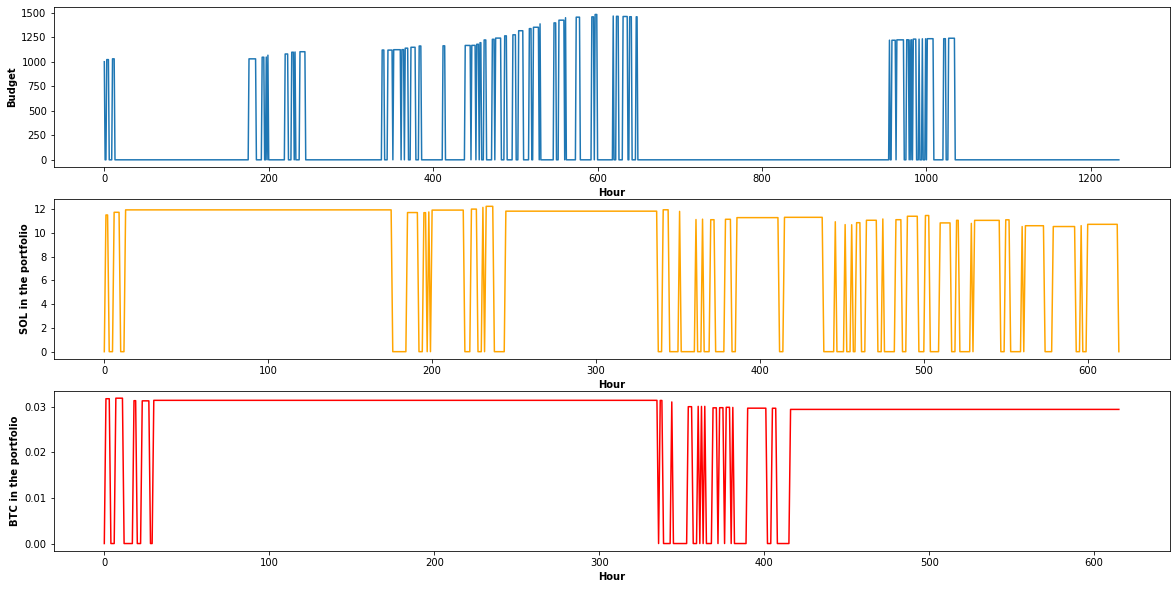

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget", fontweight="bold")
ax1.set_xlabel("Hour", fontweight="bold")

ax2.plot(btcs_hist_sol,color="orange")
ax2.set_ylabel("SOL in the portfolio", fontweight="bold")
ax2.set_xlabel("Hour", fontweight="bold")

ax3.plot(btcs_hist_btc,color="red")
ax3.set_ylabel("BTC in the portfolio", fontweight="bold")
ax3.set_xlabel("Hour", fontweight="bold")

#Moving AVG

In [ ]:
df_lgbm_ma_btc.tail(1)

,index,price_t4,true_price_t5,lgbm_price,move_avg,coins
1233,1233,38608.63,38596.11,38349.149922,38516.19,BTC


In [ ]:
budget=1000
sol=0
budget_hist_btc=[budget]
budget_hist=[budget]
budget_hist_sol=[budget]
btcs_hist_btc=[sol]
btcs_hist_sol=[sol]
stopper=0.15
fee = 0.001
temp_buy_price=0
cost=0
n = len(df_lgbm_ma_sol)
print("total hours: ",n)
for i in range(n):
  if(i<=(n/2)):
    print("-------------------------------------")
    if (df_lgbm_ma_sol["price_t4"][i]<df_lgbm_ma_sol["move_avg"][i]) and (sol<=0):
      print("BUY: ", i)
      sol = budget/((1+fee)*df_lgbm_ma_sol["price_t4"][i])
      budget = budget - (sol*((1+fee)*df_lgbm_ma_sol["price_t4"][i]))
      budget=0
      temp_buy_price=df_lgbm_ma_sol["price_t4"][i]
      cost=(sol*((1+fee)*df_lgbm_ma_sol["price_t4"][i]))
      print("SOL buy price: ", df_lgbm_ma_sol["price_t4"][i])
      print("SOL: ", sol)
      print("budget: ", budget)
      print("cost: ", (sol*((1+fee)*df_lgbm_ma_sol["price_t4"][i])))
    elif (df_lgbm_ma_sol["price_t4"][i]>df_lgbm_ma_sol["move_avg"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
      if (df_lgbm_ma_sol["price_t4"][i]>(temp_buy_price)):
        print("SELL (Case 1): ", i)
        budget = budget + (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i]))
        print("SOL sell price: ", df_lgbm_ma_sol["price_t4"][i])
        print("SOL: ", sol)
        print("revenue: ", (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i])))
        sol = 0
      elif (((sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i]))<(cost*(1-stopper)))):
        print("SELL (Case 2): ", i)
        print("SOL buy price: ", temp_buy_price)
        print("SOL sell price: ", df_move_avg_sol["price_t4"][i])
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i])))
        budget = budget + (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i]))
        sol = 0
    # else:
    #   print("SELL: ", i)
    #   budget = budget + (sol*((1-fee)*result["price_t4"][i]))
    #   print("SOL sell price: ", result["price_t4"][i])
    #   print("SOL: ", sol)
    #   print("Stopper value: ", (cost*(1-stopper)))
    #   print("revenue: ", (sol*((1-fee)*result["price_t4"][i])))
    #   sol = 0
    budget_hist_sol=budget_hist_sol+[budget]        
    btcs_hist_sol=btcs_hist_sol+[sol]
  else:
    if(i==618):
      print("SOL Sell: ", i)
      print("SELL (Case 1): ", i)
      budget = budget + (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i]))
      print("SOL sell price: ", df_lgbm_ma_sol["price_t4"][i])
      print("SOL: ", sol)
      print("Stopper value: ", (cost*(1-stopper)))
      print("revenue: ", (sol*((1-fee)*df_lgbm_ma_sol["price_t4"][i])))
      sol = 0
      budget_hist_sol=budget_hist_sol+[budget]        
      btcs_hist_sol=btcs_hist_sol+[sol]
    print("-------------------------------------")
    if (df_lgbm_ma_btc["price_t4"][i]<df_lgbm_ma_btc["move_avg"][i]) and (sol<=0):
      print("BUY: ", i)
      sol = budget/((1+fee)*df_lgbm_ma_btc["price_t4"][i])
      budget = budget - (sol*((1+fee)*df_lgbm_ma_btc["price_t4"][i]))
      budget=0
      temp_buy_price=df_lgbm_ma_btc["price_t4"][i]
      cost=(sol*((1+fee)*df_lgbm_ma_btc["price_t4"][i]))
      print("BTC buy price: ", df_lgbm_ma_btc["price_t4"][i])
      print("BTC: ", sol)
      print("budget: ", budget)
      print("cost: ", (sol*((1+fee)*df_lgbm_ma_btc["price_t4"][i])))
    elif (df_lgbm_ma_btc["price_t4"][i]>df_lgbm_ma_btc["move_avg"][i]) and (sol>0): #and (((sol*((1-fee)*result["price_t4"][i]))<(cost*(1-stopper)))|(result["LSTM"][i]>(temp_buy_price))):
      if (df_lgbm_ma_btc["price_t4"][i]>(temp_buy_price)):
        print("SELL (Case 1): ", i)
        budget = budget + (sol*((1-fee)*df_lgbm_ma_btc["price_t4"][i]))
        print("BTC sell price: ", df_lgbm_ma_btc["price_t4"][i])
        print("BTC: ", sol)
        print("revenue: ", (sol*((1-fee)*df_lgbm_ma_btc["price_t4"][i])))
        sol = 0
      elif (((sol*((1-fee)*df_lgbm_ma_btc["price_t4"][i]))<(cost*(1-stopper)))):
        print("SELL (Case 2): ", i)
        print("BTC buy price: ", temp_buy_price)
        print("BTC sell price: ", df_lgbm_ma_btc["price_t4"][i])
        print("Stopper value: ", (cost*(1-stopper)))
        print("revenue: ", (sol*((1-fee)*df_lgbm_ma_btc["price_t4"][i])))
        budget = budget + (sol*((1-fee)*df_lgbm_ma_btc["price_t4"][i]))
        sol = 0
    if(i>618):
      budget_hist_btc=budget_hist_btc+[budget]        
      btcs_hist_btc=btcs_hist_btc+[sol]



  budget_hist=budget_hist+[budget]
  # btcs_hist=btcs_hist+[sol]

total hours:  1234
-------------------------------------
BUY:  0
SOL buy price:  86.86
SOL:  11.501277906988248
budget:  0
cost:  1000.0000000000001
-------------------------------------
SELL (Case 1):  1
SOL sell price:  87.8
SOL:  11.501277906988248
revenue:  1008.8023880333345
-------------------------------------
-------------------------------------
-------------------------------------
BUY:  4
SOL buy price:  88.3
SOL:  11.413302303962569
budget:  0
cost:  1008.8023880333345
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
--------------------

Text(0.5, 0, 'Hour')

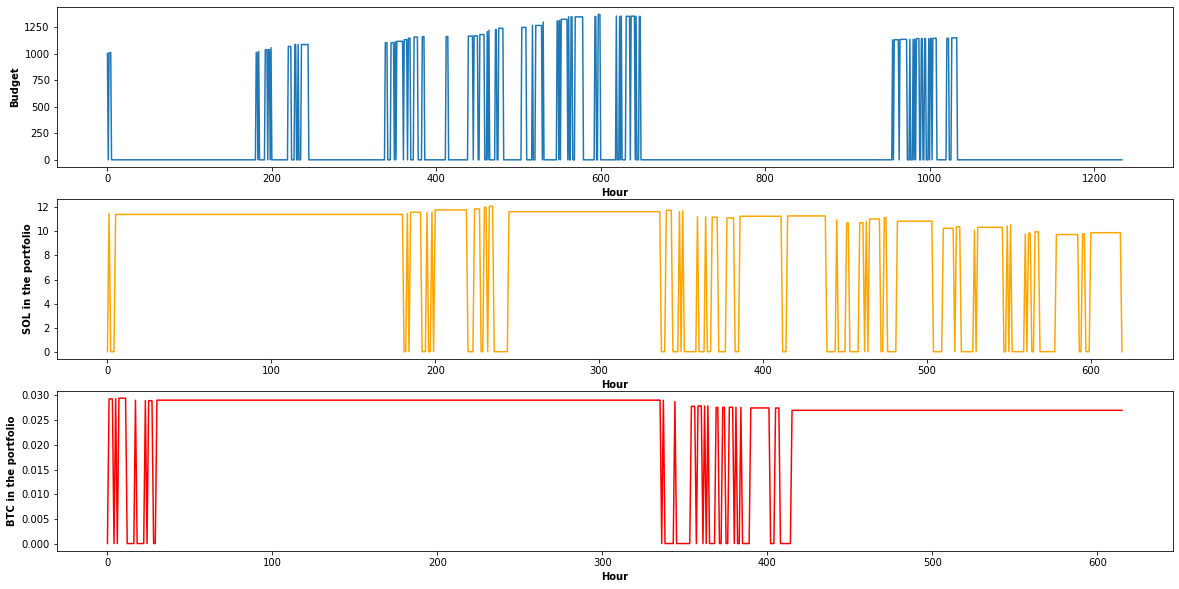

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget", fontweight="bold")
ax1.set_xlabel("Hour", fontweight="bold")

ax2.plot(btcs_hist_sol,color="orange")
ax2.set_ylabel("SOL in the portfolio", fontweight="bold")
ax2.set_xlabel("Hour", fontweight="bold")

ax3.plot(btcs_hist_btc,color="red")
ax3.set_ylabel("BTC in the portfolio", fontweight="bold")
ax3.set_xlabel("Hour", fontweight="bold")